# Simulación de un Sistema de Colas en un Banco 🏦📊

Este proyecto modela el funcionamiento de un banco durante **8 horas** de operación, utilizando un sistema de colas con varios cajeros (tellers) para atender a los clientes. Se simula el proceso de llegada de clientes, el tiempo que esperan en la cola, el tiempo que pasan siendo atendidos, y se registran métricas clave como el uso de los cajeros y la longitud de las colas a lo largo del día.

A continuación, se explican las clases principales del modelo y las métricas que se registran durante la simulación.

---

In [4]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

## Parámetros del Modelo de Simulación ⏲️

En esta simulación se utilizan varios **parámetros clave** que definen el comportamiento del sistema bancario y permiten simular las interacciones entre los clientes y los cajeros:

- **`RANDOM_SEED = 42`**: Semilla para el generador de números aleatorios, que asegura que los resultados de la simulación sean reproducibles.
- **`OPERATING_HOURS = 8 * 60`**: El banco opera durante 8 horas (convertidas en minutos). Esto representa el tiempo total de la simulación.
- **`ARRIVAL_RATE = 1`**: Tasa media de llegada de clientes, en minutos. Los clientes llegan al banco de acuerdo con una distribución exponencial con una media de 1 minuto entre llegadas.
- **`SERVICE_RATE = 4.5`**: Tasa media de servicio en minutos. Cada cliente es atendido por un cajero durante un tiempo distribuido exponencialmente con una media de 4.5 minutos.

### Métricas de Rendimiento 📊

Se definen varias **métricas** que permiten analizar el rendimiento de la simulación a lo largo del tiempo:

- **`wait_times`**: Tiempos de espera promedio de los clientes antes de ser atendidos, registrados minuto a minuto.
- **`service_times`**: Tiempos de servicio por cliente.
- **`teller_utilization`**: Utilización de cada cajero a lo largo del tiempo.
- **`queue_lengths`**: Longitud de las colas de espera en el banco en cualquier momento de la simulación.
- **`clients_served`**: Número total de clientes atendidos al final de la simulación.
- **`jockeying_events`**: Número de eventos de "jockeying", donde los clientes cambian de cola debido a diferencias en las longitudes de las filas.

Además, se utiliza una **variable global `simulation_time`** para registrar el tiempo de la simulación minuto a minuto y sincronizar las métricas registradas.

Estas constantes y métricas proporcionan los cimientos para medir y evaluar el comportamiento del banco a lo largo de la simulación.


In [5]:
# Parameters
RANDOM_SEED = 42
OPERATING_HOURS = 8 * 60  # The bank operates for 8 hours -> minutes
ARRIVAL_RATE = 1  # Mean inter-arrival time, in minutes (exponential distribution)
SERVICE_RATE = 4.5  # Mean service time, in minutes (exponential distribution)

metrics = {
    'wait_times': [],           # Average wait times over time (recorded each minute)
    'service_times': [],        # Service times per client
    'teller_utilization': [],   # Utilization per teller over time
    'queue_lengths': [],        # Queue lengths over time
    'clients_served': 0,       # Total clients served (single value)
    'jockeying_events': []      # Cumulative jockeying events over time
}

# Global clock
simulation_time = []

## Clase Cliente 👥

La clase `Client` representa a un **cliente del banco** que llega a ser atendido. Cada cliente tiene:
- **`client_id`**: Un identificador único.
- **`arrival`**: El momento en que el cliente llega al banco.
- **`delay`**: El tiempo que el cliente espera antes de ser atendido.

### Funcionamiento:
El cliente selecciona al cajero con la cola más corta y espera su turno para ser atendido. Si el cajero está ocupado, el cliente espera en la cola. Una vez que el cliente es atendido, se registra el **tiempo de servicio** y se actualiza el tiempo que el cajero ha estado ocupado.

> _Cada cliente sigue un proceso de llegada y servicio basado en distribuciones exponenciales, simulando la aleatoriedad en el sistema._

---

In [6]:
class Client:
    def __init__(self, env, client_id, bank):
        self.env = env
        self.client_id = client_id
        self.bank = bank
        self.arrival = self.env.now
        self.delay = 0
        env.process(self.client_process())

    def client_process(self):
        # The client selects the shortest queue
        teller = self.bank.select_teller()
        # If the teller is busy, the client will wait in the queue
        with teller.request() as req:
            yield req
            # Client begins service
            self.delay = self.env.now - self.arrival
            teller.record_delay(self.delay)
            service_time = random.expovariate(1 / SERVICE_RATE)
            yield self.env.timeout(service_time)
            metrics['service_times'].append(service_time)
            
            teller.time_busy += service_time

            self.bank.check_jockeying()

## Clase Cajero 🧑‍💼

La clase `Teller` representa a un **cajero** que atiende a los clientes. Cada cajero tiene:
- **`queue`**: La cola de clientes que esperan para ser atendidos.
- **`delays`**: Una lista de los tiempos de espera registrados para cada cliente.
- **`time_busy`**: El tiempo total que el cajero ha pasado atendiendo clientes.

### Funcionamiento:
Los cajeros registran los tiempos de espera de los clientes y calculan métricas como el **promedio de espera** y el **máximo tiempo de espera**. Además, el cajero también calcula su **utilización**, que refleja el porcentaje del tiempo total que ha estado ocupado.

---

In [7]:
class Teller:
    def __init__(self, env, teller_id):
        self.env = env
        self.teller_id = teller_id
        self.queue = simpy.Resource(env, capacity=1)
        self.delays = []
        self.time_busy = 0

    def request(self):
        return self.queue.request()

    def record_delay(self, delay):
        self.delays.append(delay)

    def average_delay(self):
        return np.mean(self.delays) if self.delays else 0

    def maximum_delay(self):
        return np.max(self.delays) if self.delays else 0

    def utilization(self, current_time):
        return self.time_busy / current_time if current_time > 0 else 0

## Clase Banco 🏦

La clase `Bank` coordina el sistema completo de **tellers** y **clientes**. Tiene una lista de cajeros y controla las decisiones sobre **jockeying** (cambiar de fila).

### Funcionamiento:
El banco asigna a los clientes al cajero con la cola más corta y también monitorea el **evento de jockeying**, que ocurre cuando un cliente decide cambiar de una cola más larga a una más corta si la diferencia es significativa.

> _El sistema de jockeying está diseñado para mejorar la eficiencia de la asignación de clientes._

---

In [8]:
class Bank:
    def __init__(self, env, num_tellers):
        self.env = env
        self.num_tellers = num_tellers
        self.tellers = [Teller(env, i) for i in range(num_tellers)]
        self.total_delays = []
        self.jockeying_events = 0

    def select_teller(self):
        # Choose the teller with the shortest queue
        teller = min(self.tellers, key=lambda tel: len(tel.queue.queue))
        return teller

    def check_jockeying(self):
        # Check if any client should switch queues
        for i, teller_i in enumerate(self.tellers):
            for j, teller_j in enumerate(self.tellers):
                if len(teller_j.queue.queue) > len(teller_i.queue.queue) + 1:
                    # Try to move a client from the longer queue to the shorter one
                    if teller_j.queue.count > 0:
                        self.jockeying_events += 1  # Register jockeying event

## Métodos de la Simulación 🏦

A continuación se describen tres métodos esenciales que controlan la generación de clientes, el seguimiento de métricas, y la ejecución general de la simulación del banco.

### **generate_clients(env, bank, arrival_rate)** 🚶‍♂️

Este método genera los clientes que llegan al banco de manera continua según una **distribución exponencial**. Cada cliente tiene un **`client_id`** único, que incrementa con cada llegada.

- **Proceso**: 
  - Genera un nuevo cliente después de un intervalo de tiempo determinado por la tasa de llegada (`arrival_rate`).
  - El tiempo entre llegadas se distribuye exponencialmente para simular la aleatoriedad en los tiempos de llegada.
  - Los clientes son añadidos al banco utilizando la clase `Client`.
  
- **Uso**: Este método se ejecuta en paralelo dentro del entorno de SimPy (`env.process`), simulando la entrada constante de nuevos clientes al banco.

### **track_queue_lengths(env, bank)** 📈

Este método registra las **métricas de rendimiento** clave durante la simulación, incluyendo la longitud de las colas, los tiempos de espera y los eventos de "jockeying" (cuando los clientes cambian de fila).

- **Proceso**:
  - Cada minuto de la simulación, se mide la longitud total de las colas de los cajeros.
  - Calcula el tiempo de espera promedio de los clientes en cada cajero.
  - Registra el número de eventos de "jockeying", donde los clientes cambian de cola.
  
- **Métricas registradas**:
  - Longitud de las colas (`queue_lengths`).
  - Tiempos de espera promedio (`wait_times`).
  - Eventos de jockeying (`jockeying_events`).

### **run_simulation(num_tellers)** ▶️

Este método es el encargado de **iniciar y ejecutar** la simulación completa del banco.

- **Proceso**:
  - Se inicializa el entorno de simulación (`simpy.Environment`) y el objeto `Bank` con el número de cajeros proporcionado.
  - Los procesos de generación de clientes y seguimiento de métricas se inician en paralelo.
  - La simulación se ejecuta durante el tiempo total de operación del banco (`OPERATING_HOURS`).
  - Al final de la simulación, se calcula el número total de clientes atendidos (`clients_served`).
  
- **Resultado**:
  - Devuelve el objeto `Bank`, que contiene los detalles finales de la simulación, lo que permite la creación de gráficos o análisis posteriores.

Estos métodos permiten simular y observar el comportamiento de un banco con múltiples cajeros, clientes aleatorios y colas en tiempo real.


In [9]:

def generate_clients(env, bank, arrival_rate):
    client_id = 0
    while True:
        yield env.timeout(random.expovariate(1 / arrival_rate))
        client_id += 1
        Client(env, client_id, bank)

def track_queue_lengths(env, bank):
    while True:
        queue_length = sum(len(teller.queue.queue) for teller in bank.tellers)
        metrics['queue_lengths'].append(queue_length)
        simulation_time.append(env.now)

        all_wait_times = [teller.average_delay() for teller in bank.tellers if teller.delays]
        avg_wait_time = np.mean(all_wait_times) if all_wait_times else 0
        metrics['wait_times'].append(avg_wait_time)

        metrics['jockeying_events'].append(bank.jockeying_events)

        yield env.timeout(1)  # Track every minute

def run_simulation(num_tellers):
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    bank = Bank(env, num_tellers)
    env.process(generate_clients(env, bank, ARRIVAL_RATE))
    env.process(track_queue_lengths(env, bank))
    env.run(until=OPERATING_HOURS)

    metrics['clients_served'] = len(metrics['service_times'])

    return bank  # Return the bank object for plotting


## Métricas Registradas 📊

Durante la simulación, se registran varias métricas clave para evaluar el desempeño del sistema de colas:

- **Tiempos de espera promedio**: Se calcula el tiempo que los clientes esperan antes de ser atendidos.
- **Tiempos de servicio**: El tiempo que los clientes pasan siendo atendidos por los cajeros.
- **Utilización de los cajeros**: La proporción del tiempo que los cajeros están ocupados.
- **Longitud de las colas**: La cantidad de clientes esperando en las colas.
- **Clientes atendidos**: La cantidad total de clientes que fueron atendidos durante el período de simulación.
- **Eventos de jockeying**: El número de veces que los clientes cambiaron de una cola más larga a una más corta.

---

## Gráficos de las Métricas 📈📉

### **1. Tiempo de espera promedio** ⏳

Este gráfico muestra el tiempo promedio que los clientes pasan esperando antes de ser atendidos a lo largo de la jornada. Un tiempo de espera prolongado puede indicar que hay una sobrecarga en los cajeros.

---

### **2. Tiempos de servicio** 🕒

Aquí se registra el tiempo que los cajeros pasan atendiendo a los clientes. Se espera que estos tiempos sigan una distribución exponencial.

---

### **3. Utilización de los cajeros** ⚙️

Este gráfico muestra cómo cada cajero ha sido utilizado durante el día. Un valor cercano a 1 indica que el cajero estuvo ocupado la mayor parte del tiempo, lo que puede indicar un uso eficiente, pero también el riesgo de sobrecarga.

---

### **4. Longitud de las colas** 🚶‍♂️🚶‍♀️

La longitud de las colas se mide en minutos y refleja cuántos clientes están esperando en promedio a lo largo del día.

---

### **5. Clientes atendidos** 👥✅

Este gráfico muestra cuántos clientes fueron atendidos de manera acumulativa a lo largo del día. Permite ver la capacidad del sistema para manejar el flujo de clientes.

---

### **6. Eventos de jockeying** 🔄

Los eventos de jockeying representan cuántas veces los clientes decidieron cambiarse de cola. Este es un indicador importante para evaluar la efectividad del sistema de asignación de clientes a los cajeros.

---


In [10]:

def plot_metrics(bank):
    fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # Create a 3x2 grid for subplots
    fig.suptitle('Bank Simulation Metrics', fontsize=16)

    # 1. Plot average wait times
    axs[0, 0].plot(simulation_time, metrics['wait_times'], label="Average Wait Time", color='blue')
    axs[0, 0].set_xlabel("Time (minutes)")
    axs[0, 0].set_ylabel("Wait Time (minutes)")
    axs[0, 0].set_title("Average Wait Time Over Time")
    axs[0, 0].legend()

    # 2. Plot service times
    axs[0, 1].plot(simulation_time[:len(metrics['service_times'])], metrics['service_times'], label="Service Time", color='orange')
    axs[0, 1].set_xlabel("Time (minutes)")
    axs[0, 1].set_ylabel("Service Time (minutes)")
    axs[0, 1].set_title("Service Time Over Time")
    axs[0, 1].legend()

    # 3. Plot teller utilization
    for teller in bank.tellers:
        axs[1, 0].plot(simulation_time, [teller.utilization(t) for t in simulation_time], label=f"Teller {teller.teller_id}")
    axs[1, 0].set_xlabel("Time (minutes)")
    axs[1, 0].set_ylabel("Utilization")
    axs[1, 0].set_title("Teller Utilization Over Time")
    axs[1, 0].legend()

    # 4. Plot queue lengths over time
    axs[1, 1].plot(simulation_time, metrics['queue_lengths'], label="Queue Length", color='green')
    axs[1, 1].set_xlabel("Time (minutes)")
    axs[1, 1].set_ylabel("Queue Length (Number of Clients)")
    axs[1, 1].set_title("Queue Length Over Time")
    axs[1, 1].legend()

    # 5. Plot total clients served over time
    cumulative_clients = np.arange(1, metrics['clients_served'] + 1)
    axs[2, 0].plot(simulation_time[:len(cumulative_clients)], cumulative_clients, label="Clients Served", color='purple')
    axs[2, 0].set_xlabel("Time (minutes)")
    axs[2, 0].set_ylabel("Cumulative Clients Served")
    axs[2, 0].set_title("Cumulative Clients Served Over Time")
    axs[2, 0].legend()

    # 6. Plot jockeying events over time
    axs[2, 1].plot(simulation_time, metrics['jockeying_events'], label="Jockeying Events", color='red')
    axs[2, 1].set_xlabel("Time (minutes)")
    axs[2, 1].set_ylabel("Cumulative Jockeying Events")
    axs[2, 1].set_title("Cumulative Jockeying Events Over Time")
    axs[2, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the main title
    plt.show()

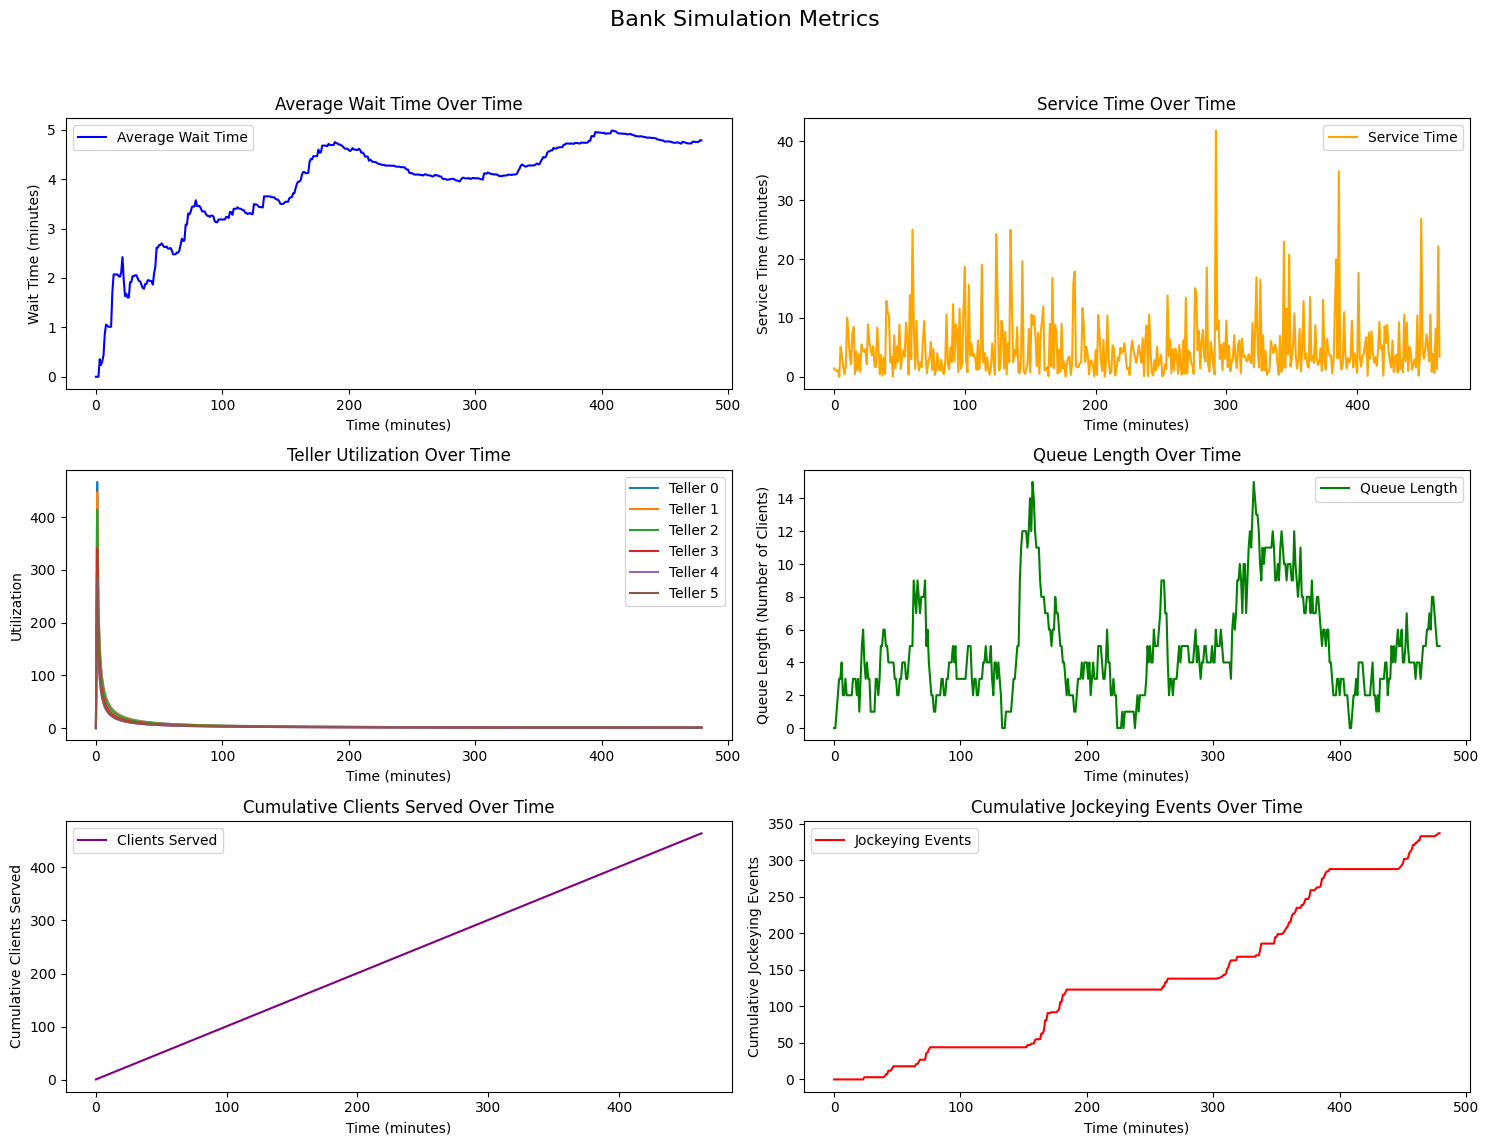

In [11]:
# Run the simulation and plot the metrics
if __name__ == '__main__':
    bank = run_simulation(6)
    plot_metrics(bank)
